# CIFAR-10 Training with Custom CNN Architecture

This notebook implements a custom CNN architecture for CIFAR-10 with:
- Depthwise Separable Convolution
- Dilated Convolution
- Global Average Pooling
- Advanced data augmentation using albumentations


# CIFAR-10 Training with Custom CNN Architecture

This notebook implements a custom CNN architecture for CIFAR-10 with:
- Depthwise Separable Convolution
- Dilated Convolution
- Global Average Pooling
- Advanced data augmentation using albumentations


In [1]:
# Create all necessary Python files

# Create dataset.py
%%writefile dataset.py
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import Dataset

class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

def get_initial_dataloaders(batch_size=128):
    """Get dataloaders with basic transforms for mean/std calculation"""
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

    basic_transform = A.Compose([
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])

    return get_dataloaders(
        batch_size=batch_size,
        transform_train=basic_transform,
        transform_test=basic_transform
    )

def get_dataloaders(batch_size, transform_train, transform_test):
    trainset = datasets.CIFAR10(
        root='./data', train=True, download=True
    )
    testset = datasets.CIFAR10(
        root='./data', train=False, download=True
    )

    train_dataset = CIFAR10Dataset(trainset, transform_train)
    test_dataset = CIFAR10Dataset(testset, transform_test)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, test_loader


Writing dataset.py


In [2]:
# Create transforms.py
%%writefile transforms.py
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class Transforms:
    def __init__(self, mean, std):
        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.CoarseDropout(
                max_holes=1, max_height=16, max_width=16,
                min_holes=1, min_height=16, min_width=16,
                fill_value=mean, mask_fill_value=None,
                p=0.5
            ),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

        self.test_transforms = A.Compose([
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])


Writing transforms.py


In [3]:
# Create utils.py
%%writefile utils.py
import torch
import matplotlib.pyplot as plt
import numpy as np

def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def plot_metrics(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss vs Epoch')

    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(test_accs, label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Accuracy vs Epoch')

    plt.show()


Writing utils.py


In [4]:
# Create model.py
%%writefile model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                  stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class CIFAR10Net(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10Net, self).__init__()

        # Initial convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Block with Depthwise Separable Convolution
        self.conv2 = nn.Sequential(
            DepthwiseSeparableConv(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Block with Dilated Convolution
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Final block with strided convolution
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Global Average Pooling and final FC layer
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x


Writing model.py


In [5]:
# Create train.py
%%writefile train.py
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from model import CIFAR10Net
from dataset import get_dataloaders
from transforms import Transforms
from utils import AverageMeter, plot_metrics, get_mean_std

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()

    pbar = tqdm(train_loader, desc='Training')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()

        train_loss.update(loss.item(), data.size(0))
        train_acc.update(100. * correct / data.size(0), data.size(0))

        pbar.set_postfix({'Loss': f'{train_loss.avg:.4f}',
                         'Acc': f'{train_acc.avg:.2f}%'})

    return train_loss.avg, train_acc.avg

def test_epoch(model, test_loader, criterion, device):
    model.eval()
    test_loss = AverageMeter()
    test_acc = AverageMeter()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()

            test_loss.update(loss.item(), data.size(0))
            test_acc.update(100. * correct / data.size(0), data.size(0))

    print(f'\nTest set: Average loss: {test_loss.avg:.4f}, '
          f'Accuracy: {test_acc.avg:.2f}%\n')

    return test_loss.avg, test_acc.avg

def main(model=None, train_loader=None, test_loader=None, device=None,
         num_epochs=50, learning_rate=0.001):
    """
    Main training function that can be called from notebook or command line
    """
    # Set device if not provided
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # If model and data loaders are not provided, create them
    if model is None or train_loader is None or test_loader is None:
        # Get dataloaders
        temp_loader, _ = get_initial_dataloaders(batch_size=128)
        mean, std = get_mean_std(temp_loader)

        transforms = Transforms(mean.tolist(), std.tolist())
        train_loader, test_loader = get_dataloaders(
            batch_size=128,
            transform_train=transforms.train_transforms,
            transform_test=transforms.test_transforms
        )

        # Initialize model
        model = CIFAR10Net().to(device)

    # Initialize criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training history
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    # Training loop
    for epoch in range(num_epochs):
        print(f'\nEpoch: {epoch+1}/{num_epochs}')

        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        test_loss, test_acc = test_epoch(
            model, test_loader, criterion, device
        )

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # Plot metrics
        if (epoch + 1) % 5 == 0:
            plot_metrics(train_losses, train_accs, test_losses, test_accs)

if __name__ == '__main__':
    main()


Writing train.py


In [6]:
# Install required packages and restart runtime
%pip install albumentations torchsummary
print("\nPlease restart the runtime now and run all cells after restart.")



Please restart the runtime now and run all cells after restart.


In [7]:
# Import all necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import our custom modules
from model import CIFAR10Net
from dataset import CIFAR10Dataset, get_dataloaders, get_initial_dataloaders
from transforms import Transforms
from utils import AverageMeter, plot_metrics, get_mean_std

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [8]:
# Initialize model
model = CIFAR10Net().to(device)

# Print model summary
from torchsummary import summary
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]             640
            Conv2d-8          [-1, 128, 32, 32]           8,320
DepthwiseSeparableConv-9          [-1, 128, 32, 32]               0
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]         147,584
      BatchNorm2d-13          [-1, 128, 32, 32]             256
             ReLU-14          [-1, 

In [9]:
# Get dataloaders with initial transforms to calculate mean/std
temp_loader, _ = get_initial_dataloaders(batch_size=128)
mean, std = get_mean_std(temp_loader)
print(f"Dataset mean: {mean.tolist()}, std: {std.tolist()}")

# Create transforms with calculated mean and std
transforms = Transforms(mean.tolist(), std.tolist())

# Create final dataloaders with proper transforms
train_loader, test_loader = get_dataloaders(
    batch_size=128,
    transform_train=transforms.train_transforms,
    transform_test=transforms.test_transforms
)


100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


Dataset mean: [-0.017212819308042526, -0.03568915277719498, -0.10692785680294037], std: [0.4940808415412903, 0.4869847893714905, 0.5231732726097107]


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/content/transforms.py:10: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(



Epoch: 1/50


Training: 100%|██████████| 391/391 [01:52<00:00,  3.47it/s, Loss=0.3099, Acc=89.17%]



Test set: Average loss: 0.4556, Accuracy: 84.47%


Epoch: 2/50


Training: 100%|██████████| 391/391 [01:51<00:00,  3.49it/s, Loss=0.2893, Acc=89.79%]



Test set: Average loss: 0.5348, Accuracy: 82.99%


Epoch: 3/50


Training: 100%|██████████| 391/391 [01:52<00:00,  3.48it/s, Loss=0.2779, Acc=90.22%]



Test set: Average loss: 0.4691, Accuracy: 84.62%


Epoch: 4/50


Training: 100%|██████████| 391/391 [01:51<00:00,  3.49it/s, Loss=0.2687, Acc=90.57%]



Test set: Average loss: 0.4573, Accuracy: 86.12%


Epoch: 5/50


Training: 100%|██████████| 391/391 [01:52<00:00,  3.49it/s, Loss=0.2572, Acc=91.01%]



Test set: Average loss: 0.4137, Accuracy: 86.77%



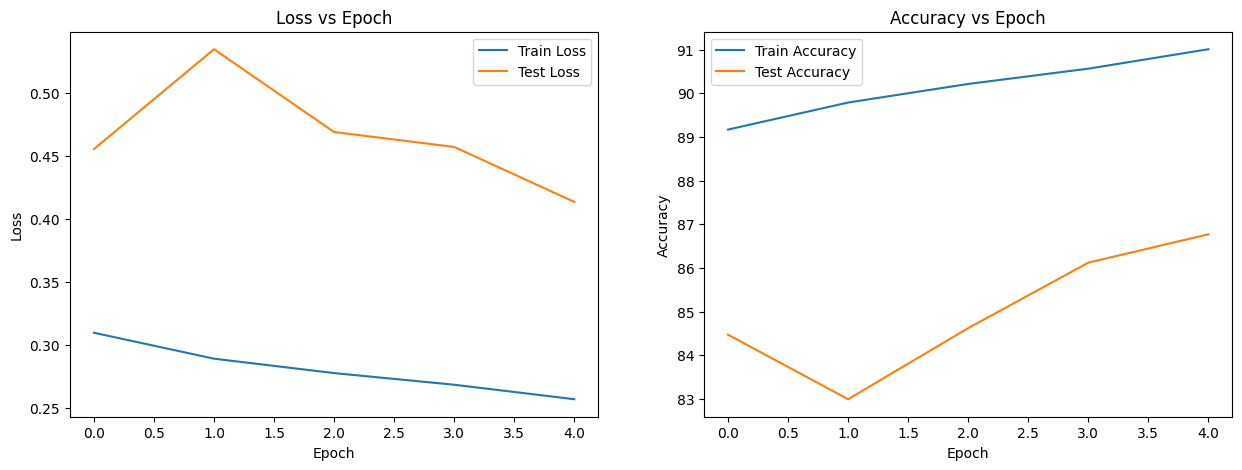


Epoch: 6/50


Training:  89%|████████▉ | 348/391 [01:39<00:12,  3.49it/s, Loss=0.2481, Acc=91.31%]

In [ ]:
# Import the main training function
from train import main

# Run training
main(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=50,
    learning_rate=0.001
)
